In [1]:
import tensorflow as tf
# 預設情況下，tensorflow會為了避免碎片化的記憶體造成效能不佳的情況而一次性的佔用顯卡所有記憶體，
# 這部份可以透過tf.config來限制硬體資源以及指定顯卡記憶體的使用。
def select_gpu(N):
    gpus = tf.config.experimental.list_physical_devices('GPU')
    print(gpus)
    if gpus:
        try:
            for gpu in gpus:
                # If memory growth is enabled for a PhysicalDevice, 
                # the runtime initialization will not allocate all memory on the device. 
                # Memory growth cannot be configured on a PhysicalDevice with virtual devices configured.
                tf.config.experimental.set_memory_growth(gpu, True)
            # 指定使用哪顆GPU
            tf.config.experimental.set_visible_devices(gpus[N], 'GPU')
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            print(e)

In [2]:
select_gpu(2) 
epochs = 10
model_name = 'bert-base'
sequence_length = 48

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]
3 Physical GPUs, 1 Logical GPUs


In [3]:
import pandas as pd
import numpy as np
import json

In [4]:
data_path = '/home/Danny/Data-Mining/lab2/kaggle/data/'

In [5]:
json_list = list()
with open(data_path + 'tweets_DM.json' , 'r') as file:
    for line in file:
        json_list.append(json.loads(line))

In [6]:
tweet_list = list()
for json in json_list:
    tweet_id = json['_source']['tweet']['tweet_id']
    hashtags = json['_source']['tweet']['hashtags']
    hashtag = ' '.join(hashtags)
    text = json['_source']['tweet']['text']
#     text = text + ' ' + hashtag
    tweet_list.append([tweet_id, text])

In [7]:
emotion_df = pd.read_csv(data_path + 'emotion.csv')
emotion_df

,tweet_id,emotion
0,0x3140b1,sadness
1,0x368b73,disgust
2,0x296183,anticipation
3,0x2bd6e1,joy
4,0x2ee1dd,anticipation
...,...,...
1455558,0x38dba0,joy
1455559,0x300ea2,joy
1455560,0x360b99,fear
1455561,0x22eecf,joy


In [8]:
identification_df = pd.read_csv(data_path + 'data_identification.csv')
identification_df

,tweet_id,identification
0,0x28cc61,test
1,0x29e452,train
2,0x2b3819,train
3,0x2db41f,test
4,0x2a2acc,train
...,...,...
1867530,0x227e25,train
1867531,0x293813,train
1867532,0x1e1a7e,train
1867533,0x2156a5,train


In [9]:
emoji_dict = {
    "😂": "lolface",
    "😇": "smile",
    "😀": "smile",
    "🎉": "party",
    "😳": "embarrassed",
    "😔": "sadface",
    "👀": "shifty",
    "🤷": "shrugging",
    "💔": "brokenhearted",
    "👻": "ghost",
    "😍": "heart",
    "🙄": "disdain",
    "💖": "heart",
    "✌": "victory",
    "🎶": "music",
    "😱": "shock",
    "😃": "smile",
    "😒": "unsatisfied",
    "👊": "brofist",
    "😄": "smile",
    "🌞": "smile",
    "🙌": "celebration",
    "😁": "smile",
    "🤗": "hugging",
    "🤣": "rofl",
    "🌈": "gaypride",
    "😉": "winking",
    "💞": "heart",
    "🙃": "irony",
    "😜": "winking",
    "😭": "bawling",
    "🤔": "thinker",
    "😎": "cool",
    "💛": "heart",
    "💚": "heart",
    "💃": "fun",
    "💗": "heart",
    "😬": "awkward",
    "😌": "relieved",
    "😅": "whew",
    "💋": "kiss",
    "🙈": "laugh",
    "😊": "^^",
    "👌": "okay",
    "😡": "angry",
    "😘": "kiss",
    "😩": "weary",
    "🔥": "excellent",
    "💙": "heart",
    "💕": "heart",
    "👏": "clapping",
    "👍": "thumbsup",
    "💯": "perfect",
    "💜": "heart",
    "🕘" : "late",
    "😡" : "angry",
    "😒" : "dissatisfied",
    "😤" : "angry",
    "😠" : "angry",
    "😑" : "annoy",
    "😰": "anxious",
    "😯": "surprise",
    "😨": "scared",
    "😲": "astonished",
    "💪": "strong",
    "🤦": "facepalm",
    "✨": "sparkle",
    "😢": "crying",
    "💓": "heart",
    "👑": "crown",
    "🤘": "rockon",
    "🌹": "rose",
    "😋": "delicious",
    "😏": "flirting",
    "😆": "XD",
    "😫": "exhausted",
    "😦": "frowning",
    "🙏": "please",
}

In [10]:
frequent_name_dict = {
    "#realdonaldtrump": "sadness",
    "#fifthharmony": "sadness",
    "#mostrequestlive": "sadness",
    "#onairromeo": "sadness",
    "#matthardybrand": "sadness",
}

In [11]:
text_df = pd.DataFrame(tweet_list, columns=['tweet_id', 'text'])
text_df

,tweet_id,text
0,0x376b20,"People who post ""add me on #Snapchat"" must be ..."
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #..."
2,0x28b412,"Confident of your obedience, I write to you, k..."
3,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>
4,0x2de201,"""Trust is not the same as faith. A friend is s..."
...,...,...
1867530,0x316b80,When you buy the last 2 tickets remaining for ...
1867531,0x29d0cb,I swear all this hard work gone pay off one da...
1867532,0x2a6a4f,@Parcel2Go no card left when I wasn't in so I ...
1867533,0x24faed,"Ah, corporate life, where you can date <LH> us..."


In [12]:
import re
def replace_word(text):
    text_list = text.split()
    for i, j in enumerate(text_list):
        if j in emoji_dict:
            text_list[i] = emoji_dict[j]
        if j in frequent_name_dict:
            text_list[i] = frequent_name_dict[j]
    text = ' '.join(text_list)
    text = re.sub('<lh>|<|>|@|#|', '', text)
    return text.split()

In [13]:
%%time
import nltk
from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)

text_df['token'] = text_df['text'].apply(lambda s : s.lower())
text_df['token'] = text_df['token'].apply(lambda s : tweet_tokenizer.tokenize(s))
text_df['token'] = text_df['token'].apply(lambda s : ' '.join(s))
text_df['token'] = text_df['token'].apply(lambda s : replace_word(s))

# text_df['token'] = text_df['text'].apply(lambda s : s.split())
text_df

CPU times: user 2min 22s, sys: 20 s, total: 2min 42s
Wall time: 2min 43s


,tweet_id,text,token
0,0x376b20,"People who post ""add me on #Snapchat"" must be ...","[people, who, post, "", add, me, on, snapchat, ..."
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...","[as, we, see, ,, trump, is, dangerous, to, fre..."
2,0x28b412,"Confident of your obedience, I write to you, k...","[confident, of, your, obedience, ,, i, write, ..."
3,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,"[now, issa, is, stalking, tasha, lolface, lolf..."
4,0x2de201,"""Trust is not the same as faith. A friend is s...","["", trust, is, not, the, same, as, faith, ., a..."
...,...,...,...
1867530,0x316b80,When you buy the last 2 tickets remaining for ...,"[when, you, buy, the, last, 2, tickets, remain..."
1867531,0x29d0cb,I swear all this hard work gone pay off one da...,"[i, swear, all, this, hard, work, gone, pay, o..."
1867532,0x2a6a4f,@Parcel2Go no card left when I wasn't in so I ...,"[no, card, left, when, i, wasn't, in, so, i, h..."
1867533,0x24faed,"Ah, corporate life, where you can date <LH> us...","[ah, ,, corporate, life, ,, where, you, can, d..."


In [14]:
test_df = identification_df[identification_df['identification'] == 'test']
# test_df

In [15]:
train_df = text_df.merge(emotion_df, left_on='tweet_id', right_on='tweet_id')
# train_df

In [16]:
x_list = train_df['token'].to_list()
y_list = train_df['emotion'].to_list()
print(len(x_list))
print(len(y_list))

1455563
1455563


In [17]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(x_list, y_list, test_size=0.2, random_state=42)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
print(len(train_x), len(train_y))
print(len(test_x), len(test_y))
print(len(valid_x), len(valid_y))

931560 931560
291113 291113
232890 232890


In [18]:
%%time
import kashgari
from kashgari.tasks.classification import BiLSTM_Model
kashgari.config.use_cudnn_cell = True
import logging
logging.basicConfig(level='DEBUG')
from kashgari.embeddings import BertEmbedding
bert_embed = BertEmbedding('/home/Danny/pretrain_model/{}'.format(model_name))
model = BiLSTM_Model(bert_embed, 
                     sequence_length=sequence_length,
#                      sequence_length: Union[str, int] = 'auto',
                    )
history = model.fit(train_x, 
                    train_y, 
                    valid_x, 
                    valid_y,
                    epochs=epochs,
                    batch_size=256,
         )

2020-12-03 22:56:08,126 [DEBUG] kashgari - ------------------------------------------------
2020-12-03 22:56:08,127 [DEBUG] kashgari - Loaded transformer model's vocab
2020-12-03 22:56:08,127 [DEBUG] kashgari - config_path       : /home/Danny/pretrain_model/bert-base/bert_config.json
2020-12-03 22:56:08,128 [DEBUG] kashgari - vocab_path      : /home/Danny/pretrain_model/bert-base/vocab.txt
2020-12-03 22:56:08,128 [DEBUG] kashgari - checkpoint_path : /home/Danny/pretrain_model/bert-base/bert_model.ckpt
2020-12-03 22:56:08,133 [DEBUG] kashgari - Top 50 words    : ['[PAD]', '[unused0]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unused5]', '[unused6]', '[unused7]', '[unused8]', '[unused9]', '[unused10]', '[unused11]', '[unused12]', '[unused13]', '[unused14]', '[unused15]', '[unused16]', '[unused17]', '[unused18]', '[unused19]', '[unused20]', '[unused21]', '[unused22]', '[unused23]', '[unused24]', '[unused25]', '[unused26]', '[unused27]', '[unused28]', '[unused29]', '[unused30]'

Epoch 1/10
3638/3638 [==============================] - 1494s 411ms/step - loss: 1.3701 - accuracy: 0.4990 - val_loss: 1.2884 - val_accuracy: 0.5318
Epoch 2/10
3638/3638 [==============================] - 1494s 411ms/step - loss: 1.2748 - accuracy: 0.5369 - val_loss: 1.2571 - val_accuracy: 0.5419
Epoch 3/10
3638/3638 [==============================] - 1493s 411ms/step - loss: 1.2352 - accuracy: 0.5517 - val_loss: 1.2432 - val_accuracy: 0.5496
Epoch 4/10
3638/3638 [==============================] - 1494s 411ms/step - loss: 1.2084 - accuracy: 0.5618 - val_loss: 1.2420 - val_accuracy: 0.5511
Epoch 5/10
3638/3638 [==============================] - 1492s 410ms/step - loss: 1.1877 - accuracy: 0.5692 - val_loss: 1.2442 - val_accuracy: 0.5521
Epoch 6/10
3638/3638 [==============================] - 1493s 410ms/step - loss: 1.1711 - accuracy: 0.5754 - val_loss: 1.2453 - val_accuracy: 0.5518
Epoch 7/10
3638/3638 [==============================] - 1549s 426ms/step - loss: 1.1570 - accuracy: 0.5801

In [19]:
model.evaluate(test_x, test_y)
model_path = 'model/{}_epoch_{}'.format(model_name, epochs)
model.save(model_path)

2020-12-04 03:14:34,764 [WARNING] kashgari - Sequence length is None, will use the max length of the samples, which is 101
2020-12-04 03:14:38,681 [DEBUG] kashgari - predict input shape (2, 291113, 101) x: 
(array([[ 101, 2042, 1037, ...,    0,    0,    0],
       [ 101, 3582, 2256, ...,    0,    0,    0],
       [ 101, 4687, 2065, ...,    0,    0,    0],
       ...,
       [ 101, 1045, 2499, ...,    0,    0,    0],
       [ 101, 1998, 2442, ...,    0,    0,    0],
       [ 101, 6343,  100, ...,    0,    0,    0]], dtype=int32), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32))
2020-12-04 03:32:30,058 [DEBUG] kashgari - predict output shape (291113, 8)
2020-12-04 03:32:30,283 [DEBUG] kashgari - predict output argmax: [0 0 3 ... 3 0 0]


              precision    recall  f1-score   support

       anger     0.5114    0.2119    0.2997      7946
anticipation     0.6308    0.5784    0.6035     49984
     disgust     0.4329    0.3283    0.3734     27669
        fear     0.4569    0.3326    0.3849     12846
         joy     0.5917    0.7541    0.6631    102943
     sadness     0.4089    0.5462    0.4677     38745
    surprise     0.5944    0.1996    0.2988      9816
       trust     0.5649    0.3487    0.4312     41164

    accuracy                         0.5464    291113
   macro avg     0.5240    0.4125    0.4403    291113
weighted avg     0.5472    0.5464    0.5320    291113



2020-12-04 03:32:46,772 [INFO] kashgari - model saved to /home/Danny/Data-Mining/lab2/kaggle/kashgari/model/bert-base_epoch_10


'/home/Danny/Data-Mining/lab2/kaggle/kashgari/model/bert-base_epoch_10'

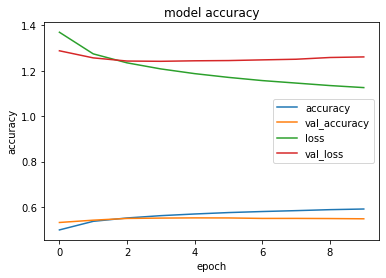

In [29]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'])
plt.show()

In [22]:
# model_path = 'model/{}_epoch_{}'.format(model_name, epochs)
# model = kashgari.utils.load_model(model_path)
# model.evaluate(test_x, test_y)

In [23]:
test_df = test_df.merge(text_df, left_on='tweet_id', right_on='tweet_id')
test_df

,tweet_id,identification,text,token
0,0x28cc61,test,@Habbo I've seen two separate colours of the e...,"[i've, seen, two, separate, colours, of, the, ..."
1,0x2db41f,test,@FoxNews @KellyannePolls No serious self respe...,"[no, serious, self, respecting, individual, be..."
2,0x2466f6,test,"Looking for a new car, and it says 1 lady owne...","[looking, for, a, new, car, ,, and, it, says, ..."
3,0x23f9e9,test,@cineworld “only the brave” just out and fount...,"[“, only, the, brave, ”, just, out, and, fount..."
4,0x1fb4e1,test,Felt like total dog 💩 going into open gym and ...,"[felt, like, total, dog, 💩, going, into, open,..."
...,...,...,...,...
411967,0x2c4dc2,test,6 year old walks in astounded. Mum! Look how b...,"[6, year, old, walks, in, astounded, ., mum, !..."
411968,0x31be7c,test,Only one week to go until the #inspiringvolunt...,"[only, one, week, to, go, until, the, inspirin..."
411969,0x1ca58e,test,"I just got caught up with the manga for ""My He...","[i, just, got, caught, up, with, the, manga, f..."
411970,0x35c8ba,test,Speak only when spoken to and make hot ass mus...,"[speak, only, when, spoken, to, and, make, hot..."


In [24]:
text_list = test_df['token'].tolist()
text_list

[["i've",
  'seen',
  'two',
  'separate',
  'colours',
  'of',
  'the',
  'elegant',
  'furni',
  'on',
  'your',
  'homepage',
  '?'],
 ['no',
  'serious',
  'self',
  'respecting',
  'individual',
  'believes',
  'much',
  'less',
  'agrees',
  'w',
  'her'],
 ['looking',
  'for',
  'a',
  'new',
  'car',
  ',',
  'and',
  'it',
  'says',
  '1',
  'lady',
  'owner',
  '.',
  'that',
  'means',
  'needs',
  'new',
  'clutch',
  ',',
  'gearbox',
  'and',
  'brakes',
  '.',
  'womendrivers'],
 ['“',
  'only',
  'the',
  'brave',
  '”',
  'just',
  'out',
  'and',
  'fountain',
  'park',
  'have',
  'only',
  '3',
  'showings',
  'per',
  'day',
  '!',
  'robbingmembers'],
 ['felt',
  'like',
  'total',
  'dog',
  '💩',
  'going',
  'into',
  'open',
  'gym',
  'and',
  'had',
  'a',
  'migraine',
  'played',
  'through',
  'and',
  'sweated',
  'it',
  'out',
  'and',
  'my',
  'sweat',
  'has',
  'never',
  'been',
  'that',
  'bad',
  '.'],
 ['rysenshyne',
  'plz',
  'ply',
  'me',
 

In [25]:
predict_list = model.predict(text_list)
predict_list

2020-12-04 03:33:05,547 [DEBUG] kashgari - predict input shape (2, 411972, 96) x: 
(array([[ 101,  100, 2464, ...,    0,    0,    0],
       [ 101, 2053, 3809, ...,    0,    0,    0],
       [ 101, 2559, 2005, ...,    0,    0,    0],
       ...,
       [ 101, 1045, 2074, ...,    0,    0,    0],
       [ 101, 3713, 2069, ...,    0,    0,    0],
       [ 101, 2113, 2054, ...,    0,    0,    0]], dtype=int32), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32))
2020-12-04 03:57:29,163 [DEBUG] kashgari - predict output shape (411972, 8)
2020-12-04 03:57:29,491 [DEBUG] kashgari - predict output argmax: [3 1 3 ... 3 0 0]


['sadness',
 'anticipation',
 'sadness',
 'joy',
 'disgust',
 'joy',
 'joy',
 'anticipation',
 'sadness',
 'sadness',
 'sadness',
 'sadness',
 'sadness',
 'trust',
 'joy',
 'joy',
 'joy',
 'joy',
 'joy',
 'joy',
 'disgust',
 'sadness',
 'anticipation',
 'joy',
 'trust',
 'anticipation',
 'joy',
 'disgust',
 'joy',
 'joy',
 'anger',
 'trust',
 'joy',
 'joy',
 'sadness',
 'trust',
 'anticipation',
 'joy',
 'anticipation',
 'sadness',
 'joy',
 'sadness',
 'sadness',
 'sadness',
 'sadness',
 'joy',
 'anticipation',
 'trust',
 'joy',
 'joy',
 'sadness',
 'joy',
 'joy',
 'joy',
 'joy',
 'disgust',
 'anticipation',
 'sadness',
 'joy',
 'disgust',
 'joy',
 'joy',
 'trust',
 'joy',
 'joy',
 'joy',
 'joy',
 'sadness',
 'disgust',
 'trust',
 'sadness',
 'joy',
 'joy',
 'joy',
 'joy',
 'sadness',
 'anticipation',
 'disgust',
 'joy',
 'sadness',
 'anticipation',
 'sadness',
 'sadness',
 'trust',
 'disgust',
 'sadness',
 'joy',
 'joy',
 'sadness',
 'anticipation',
 'joy',
 'anticipation',
 'joy',
 '

In [26]:
test_df['predict'] = predict_list
test_df

,tweet_id,identification,text,token,predict
0,0x28cc61,test,@Habbo I've seen two separate colours of the e...,"[i've, seen, two, separate, colours, of, the, ...",sadness
1,0x2db41f,test,@FoxNews @KellyannePolls No serious self respe...,"[no, serious, self, respecting, individual, be...",anticipation
2,0x2466f6,test,"Looking for a new car, and it says 1 lady owne...","[looking, for, a, new, car, ,, and, it, says, ...",sadness
3,0x23f9e9,test,@cineworld “only the brave” just out and fount...,"[“, only, the, brave, ”, just, out, and, fount...",joy
4,0x1fb4e1,test,Felt like total dog 💩 going into open gym and ...,"[felt, like, total, dog, 💩, going, into, open,...",disgust
...,...,...,...,...,...
411967,0x2c4dc2,test,6 year old walks in astounded. Mum! Look how b...,"[6, year, old, walks, in, astounded, ., mum, !...",trust
411968,0x31be7c,test,Only one week to go until the #inspiringvolunt...,"[only, one, week, to, go, until, the, inspirin...",anticipation
411969,0x1ca58e,test,"I just got caught up with the manga for ""My He...","[i, just, got, caught, up, with, the, manga, f...",sadness
411970,0x35c8ba,test,Speak only when spoken to and make hot ass mus...,"[speak, only, when, spoken, to, and, make, hot...",joy


In [27]:
output_df = test_df[['tweet_id', 'predict']]
output_df = output_df.rename(columns={'tweet_id':'id', 'predict':'emotion'})
# output_df

In [28]:
output_path = 'output/{}_epoch_{}.csv'.format(model_name, epochs)
output_df.to_csv(output_path, index=False, header=True)